In [8]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.providers.ibmq import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import  qiskit.quantum_info as qi
import qiskit.tools.jupyter

## Device

In [2]:
qasm_sim = Aer.get_backend("qasm_simulator")
statevector_sim = Aer.get_backend("statevector_simulator")
unit_sim = Aer.get_backend("unitary_simulator")

In [9]:
qasm_sim.provider()

In [15]:
#IBMQ.load_account()  # Logging to IBMQ
provider = IBMQ.get_provider('ibm-q')
backends = least_busy(provider.backends(filters = lambda x:x.configuration().n_qubits >= 2 and not x.configuration().simulator
                             and x.status().operational==True))
backends

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [16]:
quantum_computer = provider.get_backend('ibmq_belem')

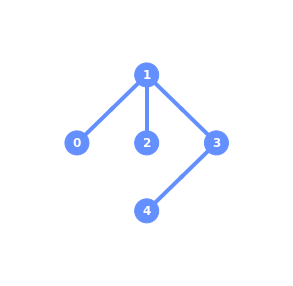

In [17]:
plot_gate_map(quantum_computer)

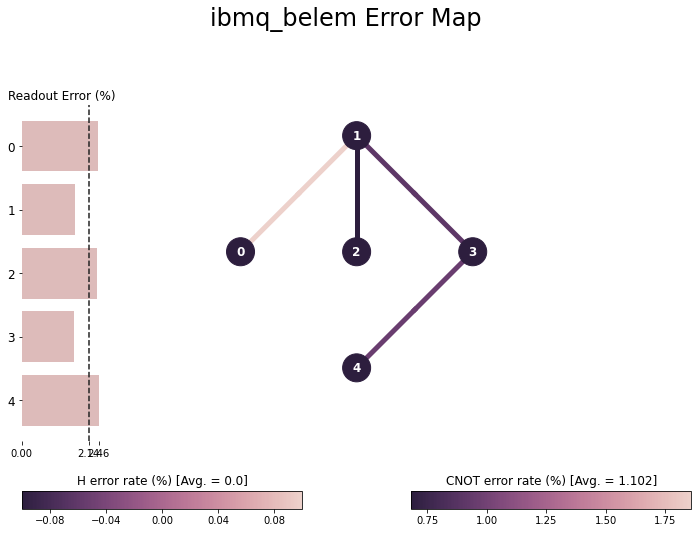

In [18]:
plot_error_map(quantum_computer)

## Circuit

In [25]:
qr = QuantumRegister(3, "q")
cr = ClassicalRegister(3, "c")

qc = QuantumCircuit(qr, cr)
qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0)
qc.cx([qr[0], qr[1]], [qr[1], qr[2]])
qc.barrier()

qc.draw()

┌─────────────────────────────┐           ░ 
q_0: ┤ initialize(0.70711,0.70711) ├──■────────░─
     └─────────────────────────────┘┌─┴─┐      ░ 
q_1: ───────────────────────────────┤ X ├──■───░─
                                    └───┘┌─┴─┐ ░ 
q_2: ────────────────────────────────────┤ X ├─░─
                                         └───┘ ░ 
c: 3/════════════════════════════════════════════

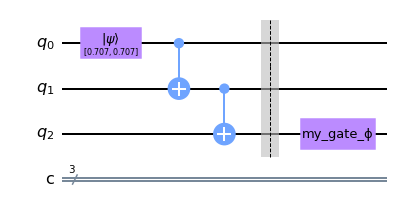

In [170]:
qreg = QuantumRegister(1)
qgate = QuantumCircuit(qreg)
qgate.h(qreg)
#qgate.cp(np.pi, 0, 1)

gate = qgate.to_gate()
gate.name = 'my_gate_ϕ'

qc.append(gate, [2])
qc.draw(output='mpl')

In [171]:
qc_decomp = qc.decompose()
qc_decomp.draw()

┌─────────────────┐           ░      
q_0: ─|0>─┤ disentangler_dg ├──■────────░──────
          └─────────────────┘┌─┴─┐      ░      
q_1: ────────────────────────┤ X ├──■───░──────
                             └───┘┌─┴─┐ ░ ┌───┐
q_2: ─────────────────────────────┤ X ├─░─┤ H ├
                                  └───┘ ░ └───┘
c: 3/══════════════════════════════════════════

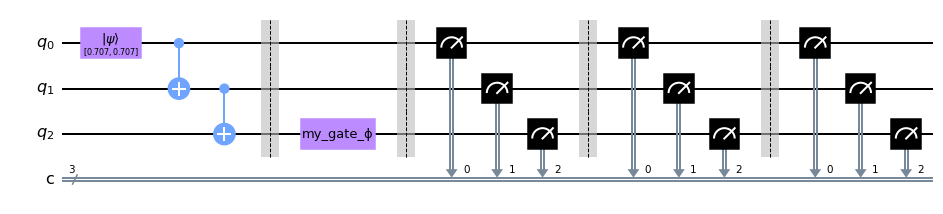

In [194]:
qc.barrier()
qc.measure(qr, cr)
circuit_drawer(qc, output='mpl')

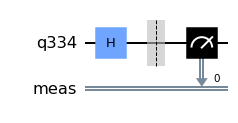

In [173]:
qgate.measure_all()
qasm_str = qgate.qasm()
qasm_str

qc_qasm = QuantumCircuit.from_qasm_str(qasm_str)
qc_qasm.draw(output="mpl")

## Execute

In [174]:
qc_job = execute(qc, qasm_sim, shorts=1024)
qc_result = qc_job.result()
qc_count = qc_result.get_counts()

qgate_job = qasm_sim.run(qgate, shots=1024)
qgate_result = qgate_job.result()
qgate_count = qgate_result.get_counts()

In [175]:
print("QC : ", qc_count)
print("QGATE : ", qgate_count)

QC :  {'000': 256, '100': 279, '111': 268, '011': 221}
QGATE :  {'0': 524, '1': 500}


## Plot

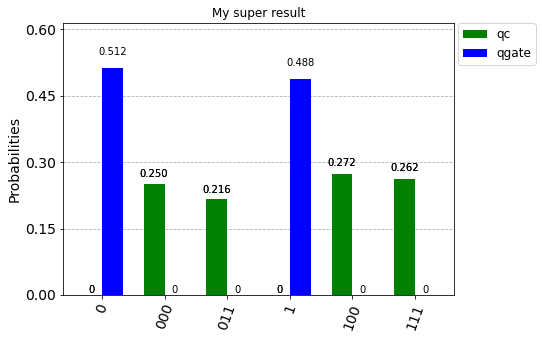

In [176]:
plot_histogram([qc_count, qgate_count], color=["green", "blue"], 
               sort="asc", legend=["qc", "qgate"], title="My super result")

In [17]:
qc_sv = QuantumCircuit(3)
#qc_sv.rx(np.pi/3, 0)
qc_sv.h(0)
qc_sv.rx(np.pi/3, 1)
qc_sv.draw()

┌───┐   
q_0: ───┤ H ├───
     ┌──┴───┴──┐
q_1: ┤ RX(π/3) ├
     └─────────┘
q_2: ───────────

In [18]:
q_operator = QuantumCircuit(2)
q_operator.cx(0, 1)
operator = qi.Operator(q_operator)
operator

qc_sv.append(q_operator, [0, 2])

qc_sv.decompose().draw()

┌─────────┐      
q_0: ┤ U2(0,π) ├───■──
     ├─────────┴┐  │  
q_1: ┤ R(π/3,0) ├──┼──
     └──────────┘┌─┴─┐
q_2: ────────────┤ X ├
                 └───┘

In [19]:
qc_job_sv = execute(qc_sv, statevector_sim).result()
qc_psi = qc_job_sv.get_statevector()

qc_psi

array([0.61237244+0.j        , 0.        +0.j        ,
       0.        -0.35355339j, 0.        +0.j        ,
       0.        +0.j        , 0.61237244+0.j        ,
       0.        +0.j        , 0.        -0.35355339j])

/usr/local/lib/python3.8/dist-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


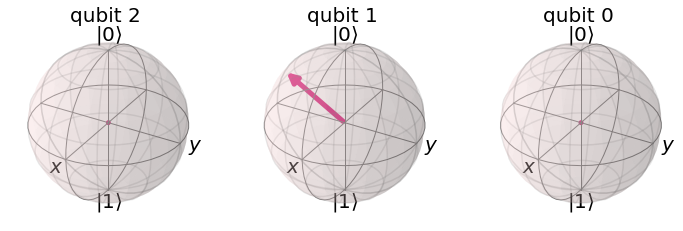

In [20]:
plot_bloch_multivector(qc_psi, reverse_bits=True)

/usr/local/lib/python3.8/dist-packages/qiskit/visualization/bloch.py:402: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
/usr/local/lib/python3.8/dist-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


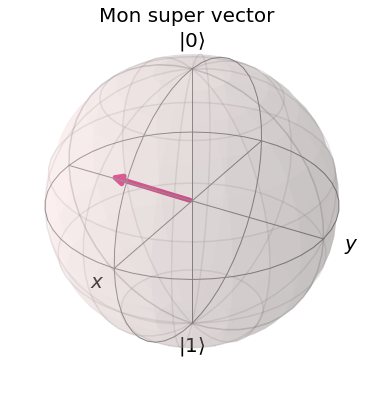

In [21]:
plot_bloch_vector([np.pi/3, 0, 1/np.sqrt(2)], title="Mon super vector")

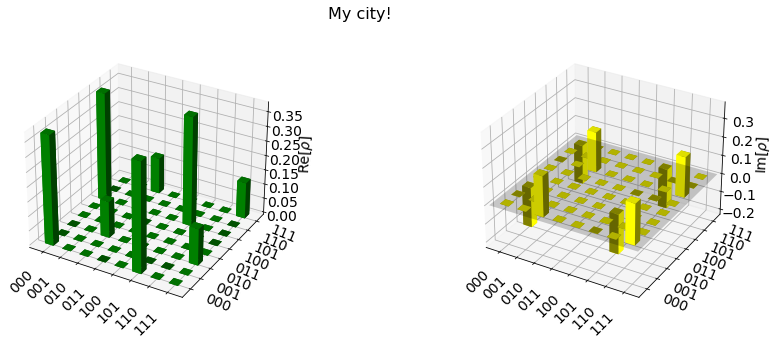

In [22]:
plot_state_city(qc_psi, title="My city!", color=["green", "yellow"])

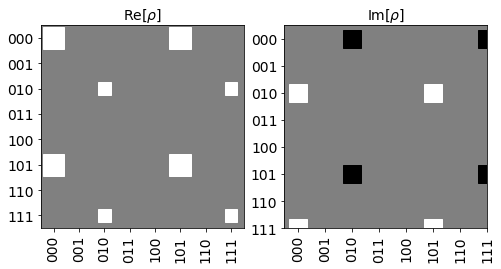

In [261]:
plot_state_hinton(qc_psi)

/usr/local/lib/python3.8/dist-packages/qiskit/visualization/state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


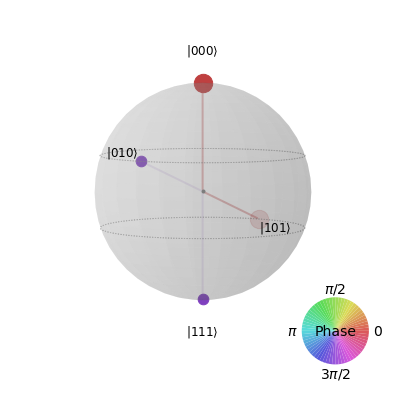

In [262]:
plot_state_qsphere(qc_psi)

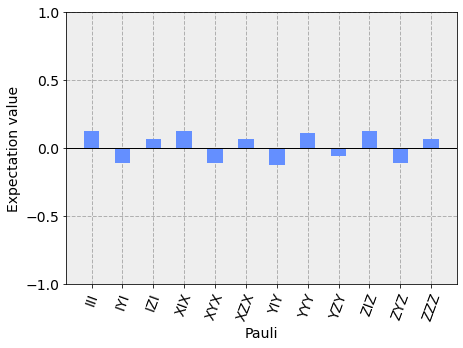

In [263]:
plot_state_paulivec(qc_psi)

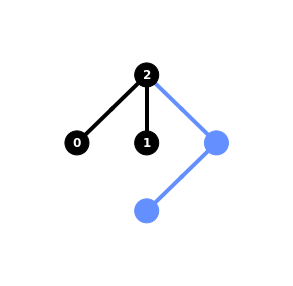

In [24]:
transpile_qc = transpile(qc_sv, backend=quantum_computer, 
                         optimization_level=3, coupling_map=[[0, 1], [1, 2]])
plot_circuit_layout(transpile_qc, quantum_computer)

In [3]:
qiskit.__version__

'0.17.4'

In [5]:
%qiskit_version_table